Simple efficiency example
====

Let's define some PDFs and an efficiency that all look like step functions:

$p_1(x) = 1, x < 0; 0.1, x > 0$  
$p_2(x) = 0.1, x < 0; 1, x > 0$

$\epsilon(x) = 1, x < 0; 0.5, x > 0$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

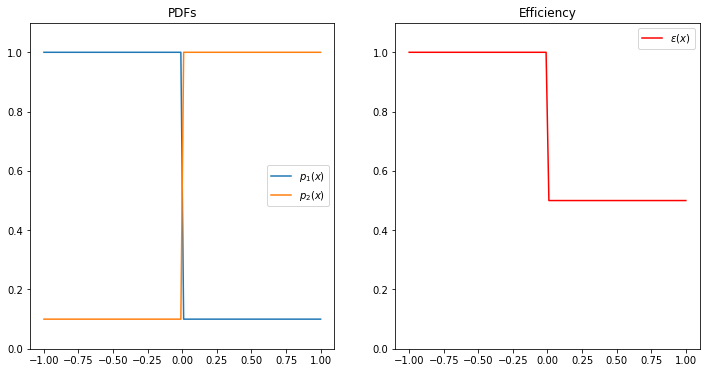

In [2]:
# Define and plot efficiency and pdfs
pdf_domain = -1.0, 1.0
pdf_range = 0.0, 1.1

def p1(x):
    if x < 0:
        return 1
    return 0.1

def p2(x):
    if x < 0:
        return 0.1
    return 1

def e(x):
    if x < 0:
        return 1
    return 0.5

domain = np.linspace(pdf_domain[0], pdf_domain[1], 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(domain, [p1(x) for x in domain], label=r"$p_1(x)$")
ax[0].plot(domain, [p2(x) for x in domain], label=r"$p_2(x)$")
ax[0].set_title("PDFs")
ax[0].set_ylim((0.0, 1.1))

ax[1].plot(domain, [e(x) for x in domain], label=r"$\epsilon(x)$", color="r")
ax[1].set_title("Efficiency")
ax[1].set_ylim((0.0, 1.1))

ax[0].legend()
ax[1].legend()
plt.show()

If we take random samples of size $N_1$ and $N_2$ from the distributions, we would expect to find
$\frac{20}{21}N_1 + \frac{1}{6}N_2$ samples in the region $x < 0$ and $\frac{5}{6}N_2 + \frac{1}{21}N_1$ samples in the region $x > 0$.

(The efficiency $\epsilon(x)$ means it is not immediately obvious (to me) what the coefficients in the above equation should be)


In [3]:
rng = np.random.default_rng()

def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    if N == 0:
        return []
    
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points

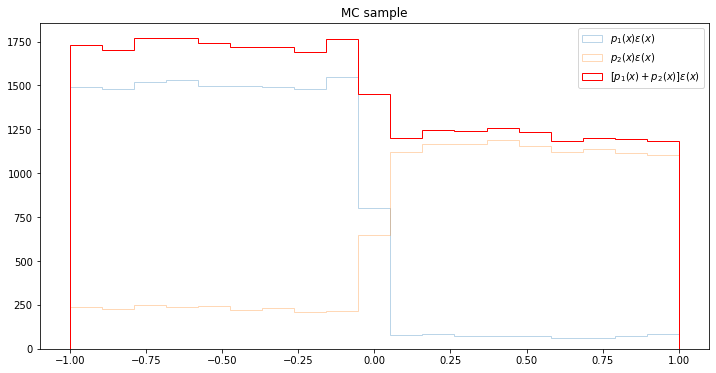

Expected:	16452.4;	11547.6	in regions x<0 and x>0
Actual:		16467;		11533


In [4]:
# Take samples from both p1(x) and p2(x); keeping the efficiency
N1, N2 = 15000, 13000

# Take samples including the efficiency
p1_sample = sample(N1, lambda x: p1(x) * e(x))
p2_sample = sample(N2, lambda x: p2(x) * e(x))

combined_sample = np.concatenate((p1_sample, p2_sample))

kw = {"bins": np.linspace(-1, 1, 20), "histtype": "step"}
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(p1_sample, **kw, label=r"$p_1(x)\epsilon(x)$", alpha=0.3)
ax.hist(p2_sample, **kw, label=r"$p_2(x)\epsilon(x)$", alpha=0.3)
ax.hist(combined_sample, **kw, label="$[p_1(x) + p_2(x)]\epsilon(x)$", color="r")
ax.legend()
ax.set_title("MC sample")
plt.show()

expected_neg = 20.0 * N1 / 21.0 + N2 / 6.0
expected_pos = 5.0 * N2 / 6.0 + N1 / 21.0

actual_neg = np.sum(combined_sample < 0)
actual_pos = np.sum(combined_sample > 0)

print(f"Expected:\t{expected_neg:.1f};\t{expected_pos:.1f}\tin regions x<0 and x>0")
print(f"Actual:\t\t{actual_neg};\t\t{actual_pos}")

The PDF describing this combined distribution is $p(x) = I_1p_1(x) + I_2p_2(x)$, with

$I_1 = \sum_i^{N_1}1/p_1(x_i)$ etc.

In our case this is $p(x) = \frac{10}{7}N_1p_1(x) + \frac{5}{2}N_2p_2(x)$.  
NB: We can scale the coefficients by anything in order to make the PDF sensible.

Postulate that the "true" PDF describing our combined distribution is $p(x)\epsilon(x)$; we should be able to find the efficiency by taking a sample from the $p(x)$:

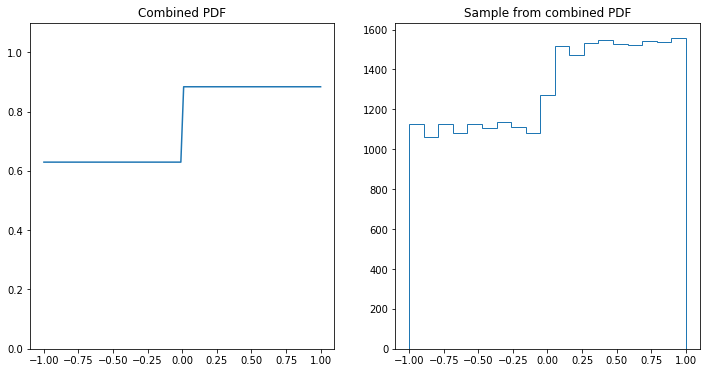

In [5]:
scale_factor = 1.4 * (N1 + N2)
def combined_pdf(x):
    return 10.0 * N1 * p1(x) / (7.0 * scale_factor) + 5.0 * N2 * p2(x) / (2.0 * scale_factor)

model = sample(25000, combined_pdf)

fig, ax = plt.subplots(1, 2, figsize=(12.0, 6.0))
ax[0].plot(domain, [combined_pdf(x) for x in domain])
ax[0].set_ylim((0.0, 1.1))
ax[0].set_title("Combined PDF")


ax[1].hist(model, **kw)
ax[1].set_title("Sample from combined PDF")

plt.show()

Now we just need to compare our sample from the combined PDF to the combined MC sample, and see if we get the right efficiency out.  
To do that, let's find the ratio of points in the regions $x > 0$ and $x < 0$: